# Bad Motor Movement Study

A re-analysis of the data used for [DESI-6135](https://desi.lbl.gov/DocDB/cgi-bin/private/ShowDocument?docid=6135) to identify groups of robots with similar motion characteristics and model the motion of the group that is most promising for use with a FastFVC.

See [DESI-6746](https://desi.lbl.gov/DocDB/cgi-bin/private/ShowDocument?docid=6746) for details.

In [1]:
%matplotlib inline

In [2]:
import json

In [3]:
from pathlib import Path

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates

In [5]:
import pandas as pd
pd.set_option('display.max_rows', 500)

In [6]:
import fpoffline.const
import fpoffline.array

In [7]:
import desietc.db

In [8]:
DESI = Path('/global/cfs/cdirs/desi')
if DESI.exists():
    DBCONFIG = DESI / 'engineering' / 'focalplane' / 'db.yaml'
    assert DBCONFIG.exists()
    DB = desietc.db.DB(config_name=DBCONFIG)
else:
    print(f'Not running at NERSC')

## Exposures

Scan one of the `*_moves.csv` files from DESI-6135 to extract the list of expids used:

In [9]:
def get_expids(file=Path('p_only/expid_83267-(127-more)-83891_moves.csv'), save='expids.json'):
    if Path(save).exists():
        with open(save) as f:
            expids = json.load(f)
    else:
        f = pd.read_csv(file)
        expids = f.EXPOSURE_ID.unique().tolist()
        with open(save, 'w') as f:
            json.dump(expids, f)
    print(f'Found {len(expids)} exposures in the range {expids[0]} - {expids[-1]}')
    return expids

expids = get_expids()

Found 129 exposures in the range 83267 - 83891


Fetch metadata for these exposures from the exposures DB:

In [10]:
def load_exps():
    sql = f'''
        select id,update_time,tileid,flavor,program
        from exposure.exposure where (id >= {expids[0]}) and (id <= {expids[-1]})
        order by id asc'''
    exps = DB.query(sql, maxrows=1000)
    sel = np.isin(exps.id, expids)
    return exps[sel]

E = load_exps()

In [11]:
E.flavor.unique()

array(['science'], dtype=object)

In [12]:
E.program.unique()

array(['DARK', 'sv1elg', 'sv1lrgqso', 'sv1lrgqso2', 'BACKUP', 'BRIGHT',
       'sv1elgqso', 'sv1bgsmws'], dtype=object)

In [13]:
E.update_time.min(), E.update_time.max()

(Timestamp('2021-04-04 05:55:45.611020+0000', tz='UTC'),
 Timestamp('2021-04-08 12:07:49.388239+0000', tz='UTC'))

## Robots

Scan the p_only, t_only, t_and_p files from DESI-6135 to extract the list of robots analyzed:

In [14]:
def get_robots(save='robots.json'):
    if Path(save).exists():
        with open(save) as f:
            robots = json.load(f)
    else:
        robots = {}
        for folder in ('p_only', 't_only', 't_and_p'):
            file = list(Path(folder).glob('*.csv'))[0]
            f = pd.read_csv(file)
            posids = f.POS_ID.unique().tolist()
            robots[folder] = posids
        with open(save, 'w') as f:
            json.dump(robots, f)            
    for rtype, posids in robots.items():
        print(f'Found {len(posids)} robots in {rtype}')
    return robots

R = get_robots()

Found 271 robots in p_only
Found 177 robots in t_only
Found 10 robots in t_and_p


In [15]:
assert set(R['p_only']).isdisjoint(set(R['t_only']))
assert set(R['p_only']).isdisjoint(set(R['t_and_p']))
assert set(R['t_only']).isdisjoint(set(R['t_and_p']))

In [16]:
posids = np.concatenate([r for r in R.values()])
rtypes = np.concatenate([np.full(len(r), k) for (k,r) in enumerate(R.values())])
print(f'Using {len(posids)} robots in total')

Using 458 robots in total


## Calibration

Load the most recent calibration record for each robot.  See [here](https://docs.google.com/spreadsheets/d/1e8yyjNFI9nCOT_KsJAxI3uzl8qSKqhuiDVXtXvxHNqM/edit#gid=836120262) for the calib schema.

In [17]:
def load_calib(name='badmotor-calib.csv'):
    
    if Path(name).exists():
        return pd.read_csv(name, index_col='pos_id', parse_dates=['time_recorded'])

    first = E.update_time.min()
    tables = []
    for petal_loc, petal_id in enumerate(fpoffline.const.PETAL_ID_MAP):
        table_name = f'posmovedb.positioner_calibration_p{petal_id}'
        sql = f'''
            select * from {table_name} where
            (time_recorded < timestamp '{first}')
        '''
        table = DB.query(sql, maxrows=100000)
        if len(table) > 0:
            print(f'Read {len(table)} rows for PETAL_LOC {petal_loc}')
        table['petal_loc'] = petal_loc
        table['location'] = 1000*petal_loc + table['device_loc']
        tables.append(table)
    calib = pd.concat(tables, axis='index', ignore_index=True)
    # Restrict to the posids used in DESI-6135.
    sel = np.isin(calib.pos_id, posids)
    calib = calib[sel]
    # Sort by increasing time.
    calib.sort_values('time_recorded', inplace=True, ignore_index=True)
    # Index by pos_id and only keep the most recent record for each robot.
    calib = calib.groupby('pos_id').last()
    # Save to csv
    calib.to_csv(name, index=True)
    
    print(f'Loaded {len(calib)} calibration records for {len(posids)} robots')
    return calib

C = load_calib()

Verify that all robots are classified functional and retracted:

In [18]:
assert np.all(~C.device_classified_nonfunctional & C.classified_as_retracted)

Check the classification of robots against their gear calibs:

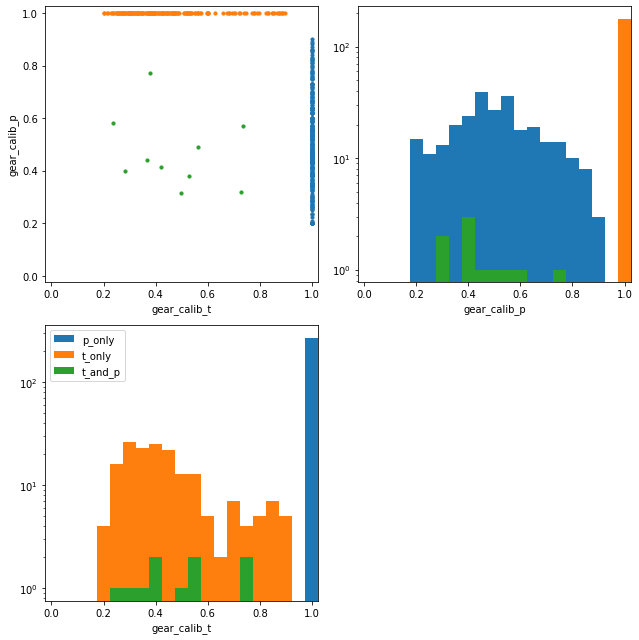

In [19]:
def plot_gear_calibs():
    calib_t = np.asarray(C.gear_calib_t)
    calib_p = np.asarray(C.gear_calib_p)
    bins = np.linspace(-0.025, 1.025, 22)
    fig, axes = plt.subplots(2, 2, figsize=(9 ,9))
    for k, label in enumerate(R.keys()):
        c = f'C{k}'
        sel1 = rtypes == k
        sel2 = np.isin(C.index, posids[sel1])
        axes[0,0].scatter(calib_t[sel2], calib_p[sel2], s=10, c=c, label=label)
        axes[0,1].hist(calib_p[sel2], bins=bins, color=c, label=label)
        axes[1,0].hist(calib_t[sel2], bins=bins, color=c, label=label)

    axes[1,1].axis('off')
    axes[0,0].set(xlim=(bins[0],bins[-1]), ylim=(bins[0],bins[-1]), xlabel='gear_calib_t', ylabel='gear_calib_p')
    axes[0,1].set(xlim=(bins[0],bins[-1]), xlabel='gear_calib_p', yscale='log')
    axes[1,0].set(xlim=(bins[0],bins[-1]), xlabel='gear_calib_t', yscale='log')
    axes[1,0].legend()
    plt.tight_layout()
    plt.savefig('gear_calibs.png')

plot_gear_calibs()

Plot robot locations (now that we have the posid => loc mapping from the calib db):

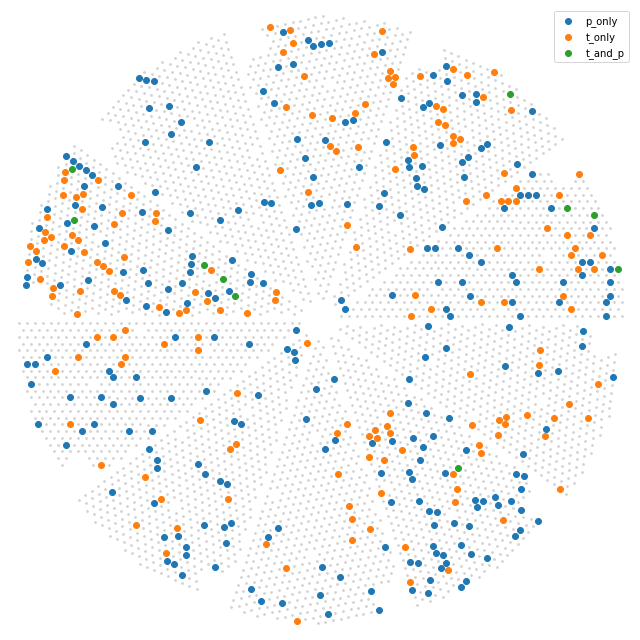

In [20]:
def plot_locs():
    FP = fpoffline.array.DeviceArray()
    all_locs = FP.where(np.isfinite)
    groups = [(all_locs, dict(c='lightgray', s=3))]
    for rtype, posids in R.items():
        locs = C.loc[posids].location.tolist()
        groups.append((locs, dict(label=rtype)))
    fig, ax = plt.subplots(figsize=(9, 9))
    fpoffline.array.plotFP(*groups, ax=ax)
    plt.tight_layout()
    plt.savefig('badlocs.png')
        
plot_locs()

Check for any changes to the calibration while this data was being collected:

In [21]:
def check_calib_changes():
    
    if not DESI.exists():
        print('DB access only works at NERSC')
        return

    first = E.update_time.min()
    last = E.update_time.max()
    
    tables = []
    for petal_loc, petal_id in enumerate(fpoffline.const.PETAL_ID_MAP):
        table_name = f'posmovedb.positioner_calibration_p{petal_id}'
        sql = f'''
            select * from {table_name} where
            (time_recorded >= timestamp '{first}') and
            (time_recorded <= timestamp '{last}')
        '''
        table = DB.query(sql, maxrows=1000)
        if len(table) > 0:
            print(f'Read {len(table)} rows for PETAL_LOC {petal_loc}')
        table['petal_loc'] = petal_loc
        table['location'] = 1000*petal_loc + table['device_loc']
        tables.append(table)
    calib = pd.concat(tables, axis='index', ignore_index=True)
    # Restrict to the posids used in DESI-6135.
    sel = np.isin(calib.pos_id, posids)
    calib = calib[sel]
    # Sort by increasing time.
    calib.sort_values('time_recorded', inplace=True, ignore_index=True)
    print(f'Found {len(calib)} new calib records')
    # Verify that none of the columns we care about have changed.
    cols = ['length_r1', 'length_r2', 'offset_x', 'offset_y', 'offset_t', 'offset_p', 'gear_calib_t', 'gear_calib_p',
            'physical_range_t', 'physical_range_p', 'device_classified_nonfunctional', 'classified_as_retracted']
    for i,row in calib.iterrows():
        old = C.loc[row.pos_id][cols].to_numpy(float)
        new = row[cols].to_numpy(float)
        assert np.allclose(old, new)
    print('No changes to columns we care about')

check_calib_changes()

Read 8 rows for PETAL_LOC 0
Read 36 rows for PETAL_LOC 1
Read 40 rows for PETAL_LOC 2
Read 10 rows for PETAL_LOC 3
Read 10 rows for PETAL_LOC 4
Read 16 rows for PETAL_LOC 5
Read 82 rows for PETAL_LOC 6
Read 48 rows for PETAL_LOC 7
Read 26 rows for PETAL_LOC 8
Read 40 rows for PETAL_LOC 9
Found 56 new calib records
No changes to columns we care about


## Moves

Load all moves for these exposures:

In [22]:
def load_all_moves(name='badmotor-moves.csv.gz'):

    if Path(name).exists():
        return pd.read_csv(name, parse_dates=['time_recorded'])

    tables = []
    first = E.update_time.min()
    last = E.update_time.max() + pd.Timedelta(2, 'hours')
    for petal_loc, petal_id in enumerate(fpoffline.const.PETAL_ID_MAP):
        table_name = f'posmovedb.positioner_moves_p{petal_id}'
        move_cols = '''
            time_recorded,device_loc,pos_id,pos_t,pos_p,ctrl_enabled,move_cmd,move_val1,move_val2,log_note,
            exposure_id,exposure_iter,flags,ptl_x,ptl_y,obs_x,obs_y
            '''
        # We don't bother sorting by time_recorded since we do it globally after concatenating all petals.
        # We also don't restrict to the subset of expids used since it is faster to do this outside SQL.
        sql = f'''
            select {move_cols} from {table_name} where
                (time_recorded > timestamp '{first}') and
                (time_recorded < timestamp '{last}')
        '''
        table = DB.query(sql, maxrows=500000)
        if len(table) > 0:
            print(f'Read {len(table)} rows for PETAL_LOC {petal_loc}')
        table['location'] = 1000*petal_loc + table['device_loc']
        table.drop(columns='device_loc', inplace=True)
        tables.append(table)
    moves = pd.concat(tables, axis='index', ignore_index=True)
    print(f'Loaded {len(moves)} moves for {len(expids)} exposures and {len(posids)} robots')
    
    # Restrict to the posids used in DESI-6135.
    sel = np.isin(moves.pos_id, posids)
    moves = moves[sel]

    # Sort by increasing time.
    moves.sort_values('time_recorded', inplace=True, ignore_index=True)
    
    # Verify that every row has valid angles POS_T,P and CTRL_ENABLED
    pos = ~(moves.pos_t.isna() | moves.pos_p.isna())
    ctrl = ~moves.ctrl_enabled.isna()
    assert np.all(pos & ctrl)

    # Calculate and save the sum of commanded T,P moves.
    # Use 0. if there is no move command for this row.
    def sum_move(col_in, col_out):
        moves[col_out] = 0.
        valid = moves[col_in].notna() #& (moves[col_in] != '')
        angle = moves[col_in].dropna().str.split('; | ').apply(lambda d: np.sum(np.array(list(map(float, d[1::2])))))
        moves.loc[valid, col_out] = angle
        #moves.drop(columns=col_in, inplace=True) # Drop the original string column
    sum_move('move_val1', 'req_dt')
    sum_move('move_val2', 'req_dp')
    
    # Flag moves where angles are updated from FVC spots.
    # Why don't these have valid OBS_X etc??
    moves['update'] = moves.log_note.str.contains('tp_update_posTP')
    
    # Replace pos_t,p with the FVC update when available.
    byloc = moves.groupby('location')
    moves['usenext'] = byloc.update.shift(-1, fill_value=False)
    moves.loc[moves['usenext'], 'pos_t'] = byloc.pos_t.shift(-1, fill_value=np.nan)
    moves.loc[moves['usenext'], 'pos_p'] = byloc.pos_p.shift(-1, fill_value=np.nan)
    
    # Calculate the actual change in pos_t,p.
    byloc = moves.groupby('location')
    moves['actual_dt'] = moves.pos_t - byloc.pos_t.shift(+1, fill_value=np.nan)
    moves['actual_dp'] = moves.pos_p - byloc.pos_p.shift(+1, fill_value=np.nan)
    
    # Save to csv.
    moves.to_csv(name, index=False, compression='gzip')
    
    return moves

all_moves = load_all_moves()

## Analysis

In [23]:
def linefit(x, y, X, max_iter=5, min_rms=0.2, max_rms=10, nsig=4, plot=False, verbose=False):
    
    assert x.shape == y.shape
    assert x.shape == X.shape
    
    assert np.all(np.isfinite(x))
    assert np.all(np.isfinite(y))

    # Mask any points where the motor appears to be stuck.
    bins = np.linspace(*np.percentile(X, (0, 100)), len(X)//5)
    moving = np.abs(x) > 1.5 * (bins[1] - bins[0])
    hist, _ = np.histogram(X[moving], bins)
    imode = np.argmax(hist)
    stuck_val = 0.5 * (bins[imode] + bins[imode+1])
    stuck_frac = hist[imode] / len(X[moving])
    if stuck_frac > max(0.2, 3 / len(bins)):
        mask = ~moving | (X < bins[imode]) | (X > bins[imode+1])
    else:
        mask = np.ones(len(x), bool)
    
    good = mask
    last = None

    for it in range(max_iter):
        
        # Fit a straight line to the good points.
        try:
            slope, offset = np.polyfit(x[good], y[good], deg=1)
        except Exception:
            return np.nan, np.nan, np.nan, good
        if verbose:
            print('fit', it, slope, offset, np.count_nonzero(good))
        fit = slope * x + offset
        resid = y - fit
        
        if plot:
            xlim = np.percentile(x, (0, 100))
            plt.plot(x[good], y[good], '.')
            plt.plot(x[~good], y[~good], 'x')
            plt.plot(xlim, slope * xlim + offset, 'k-', alpha=0.5)
            plt.show()

        # Calculate the RMS residual for the good points.
        rms = max(min_rms, min(max_rms, np.std(resid[good])))
        
        # Flag any points outside nsig cut as outliers.
        good = (np.abs(resid) < nsig * rms) & mask
        badfrac = np.count_nonzero(~good) / len(x)
        
        if last is not None and np.all(last == good):
            break

        last = good

    if np.abs(offset) > nsig * rms:
        return np.nan, np.nan, np.nan, np.nan, np.nan, good
        
    return slope, badfrac, rms, stuck_val, stuck_frac, ~good

In [24]:
def plot_tp(pos_id, moves=all_moves, ax=None, save=False):

    moves = moves[moves.pos_id == pos_id]
    sel = moves.ctrl_enabled & np.isin(moves.exposure_id, expids) & (moves.req_dt != 0) & (moves.req_dp != 0)
    moves = moves[sel]
    
    ax = ax or plt.gca()
    
    t = moves.time_recorded
    ax.plot(t, moves.pos_t, 'b.', ms=3, label='POS_T')
    ax.plot(t, moves.pos_p, 'r.', ms=3, label='POS_P')
    ax.set(ylim=(-200,200), ylabel='Motor angle [deg]')
    ax.grid()
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%m/%d"))
    #ax.xaxis.set_minor_formatter(matplotlib.dates.DateFormatter("%y-%m-%d"))
    ax.text(0.01, 0.02, pos_id, transform=ax.transAxes, fontsize=16)

    ax.legend(ncol=2, loc='center left')
    plt.tight_layout()

    if save:
        if save is True:
            save = f'{pos_id}-tp.png'
        print(f'saving {save}')
        plt.savefig(save)

saving stuck-t.pdf


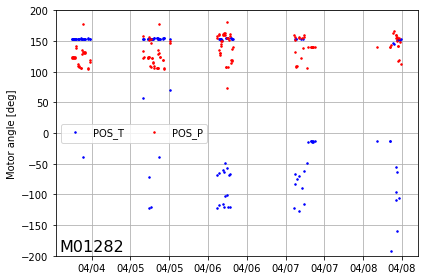

In [25]:
plot_tp('M01282', save='stuck-t.pdf')

In [26]:
def plot_moves(pos_id, moves=all_moves, ax=None, tight=False, save=False):

    calib = C.loc[pos_id]
    slope_t0 = float(calib.gear_calib_t)
    slope_p0 = float(calib.gear_calib_p)
    assert slope_t0 > 0 and slope_p0 > 0
    
    moves = moves[moves.pos_id == pos_id]
    
    sel = (moves.ctrl_enabled & np.isin(moves.exposure_id, expids)
           & (moves.req_dt != 0) & (moves.req_dp != 0)
           & np.isfinite(moves.actual_dt) & np.isfinite(moves.actual_dp))
    moves = moves[sel]
    
    size = np.full(len(moves), 5)
    size[moves.usenext] = 15
    
    ax = ax or plt.gca()

    tlim = np.array((-360, 360))
    plim = np.array((-180, 180))

    req_dt = moves.req_dt.to_numpy() / slope_t0
    act_dt = moves.actual_dt.to_numpy()
    req_dp = moves.req_dp.to_numpy() / slope_p0
    act_dp = moves.actual_dp.to_numpy()
    
    slope_t, ofrac_t, std_t, tstuck_val, tstuck_frac, bad_t = linefit(req_dt, act_dt, moves.pos_t)
    slope_p, ofrac_p, std_p, pstuck_val, pstuck_frac, bad_p = linefit(req_dp, act_dp, moves.pos_p)

    if np.any(~bad_t):
        ax.scatter(req_dt[~bad_t], act_dt[~bad_t], lw=0, c='b', s=size[~bad_t])
    if np.any(~bad_p):
        ax.scatter(2 * req_dp[~bad_p], 2 * act_dp[~bad_p], lw=0, c='r', s=size[~bad_p])
    if np.any(bad_t):
        ax.scatter(req_dt[bad_t], act_dt[bad_t], lw=1, c='b', s=size[bad_t], marker='x')
    if np.any(bad_p):
        ax.scatter(2 * req_dp[bad_p], 2 * act_dp[bad_p], lw=1, c='r', s=size[bad_p], marker='x')
    ax.plot(tlim, tlim*slope_t0, 'b--', alpha=0.5)
    ax.plot(2*plim, 2*plim*slope_p0, 'r--', alpha=0.5)
    ax.plot(tlim, tlim*slope_t, 'b-', alpha=0.1, lw=5)
    ax.plot(2*plim, 2*plim*slope_p, 'r-', alpha=0.1, lw=5)
    ax.set(aspect=1, xlim=(-360,360), ylim=(-360,360))
    if tight:
        ax.axis('off')
    else:
        ax.set(xlabel='Requested dT, 2 dP [deg]', ylabel='Actual dT, 2 dP [deg]')
        plt.tight_layout()

    ax.grid()
    ax.text(0.05, 0.9, pos_id, transform=ax.transAxes, fontsize=24)
    if np.isfinite(std_t):
        ax.text(0.05, 0.82, f'T {std_t:4.1f}° {100*ofrac_t:2.0f}% {100*tstuck_frac:2.0f}%',
                transform=ax.transAxes, fontsize=18, color='b')
    if np.isfinite(std_p):
        ax.text(0.05, 0.74, f'P {std_p:4.1f}° {100*ofrac_p:2.0f}% {100*pstuck_frac:2.0f}%',
                transform=ax.transAxes, fontsize=18, color='r')

    if save:
        if save is True:
            save = f'{pos_id}-moves.png'
        print(f'saving {save}')
        plt.savefig(save)

    return slope_t0, slope_t, ofrac_t, std_t, tstuck_val, tstuck_frac, slope_p0, slope_p, ofrac_p, std_p, pstuck_val, pstuck_frac

saving example-fit.pdf


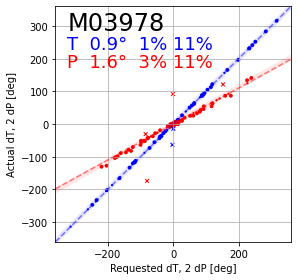

In [27]:
plot_moves('M03978', save='example-fit.pdf');

In [28]:
def plot_all(moves=all_moves, ncol=30, size=4):
    
    posids = sorted(moves.pos_id.unique())
    nplot = len(posids)
    
    results = np.empty(nplot, dtype=[('posid', np.unicode_, 6),
                                     ('slope_t0', float), ('slope_t', float), ('ofrac_t', float), ('rms_t', float),
                                     ('tstuck_val', float), ('tstuck_frac', float),
                                     ('slope_p0', float), ('slope_p', float), ('ofrac_p', float), ('rms_p', float),
                                     ('pstuck_val', float), ('pstuck_frac', float)
                                    ])

    nrow = int(np.ceil(nplot / ncol))
    w = ncol * size
    h = nrow * size
    fig, axes = plt.subplots(nrow, ncol, figsize=(w,h))
    axes = axes.reshape(-1)
    
    for k, (posid, ax) in enumerate(zip(posids, axes[:nplot])):
        if k % 100 == 0:
            print(f'done {k} of {nplot}')
        results[k] = (posid,) + plot_moves(posid, moves, ax, tight=True)

    for ax in axes[nplot:]:
        ax.axis('off')

    plt.tight_layout()
    plt.savefig('allmoves.pdf')
    plt.close(fig)
    
    results = pd.DataFrame(results)
    results.set_index('posid', inplace=True)
    results.to_csv('results.csv', index=False)
    
    return results

%time results = plot_all()

done 0 of 458
done 100 of 458
done 200 of 458
done 300 of 458
done 400 of 458
CPU times: user 1min 7s, sys: 3.65 s, total: 1min 11s
Wall time: 1min 11s


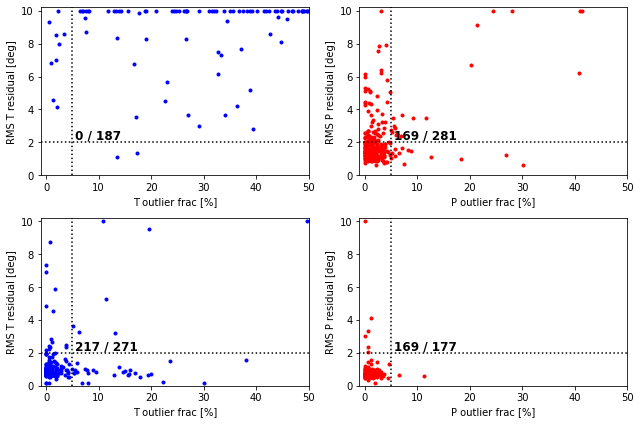

In [34]:
def plot_results(rms_cut=2, frac_cut=5):
    
    fig, axes = plt.subplots(2, 2, figsize=(9, 6))
    axes = axes.reshape(-1)
    
    bad = lambda slope: slope != 1
    good = lambda slope: slope == 1
    
    k = 0
    for cond in (bad, good):
        for (axis, Axis, color) in zip('tp', 'TP', 'br'):
            ax = axes[k]
            k += 1
            sel = cond(results[f'slope_{axis}0'])
            nsel = np.count_nonzero(sel)
            ax.plot(100*results[sel][f'ofrac_{axis}'], results[sel][f'rms_{axis}'], '.', c=color)
            ax.set(xlabel=f'{Axis} outlier frac [%]', xlim=(-1,50), ylabel=f'RMS {Axis} residual [deg]', ylim=(0,10.2))
            use = (100*results[sel][f'ofrac_{axis}'] < frac_cut) & (results[sel][f'rms_{axis}'] < rms_cut)
            nuse = np.count_nonzero(use)
            ax.axvline(frac_cut, c='k', ls=':')
            ax.axhline(rms_cut, c='k', ls=':')
            ax.text(frac_cut * 1.1, rms_cut * 1.1, f'{nuse} / {nsel}', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.savefig('results.png')

plot_results()

In [29]:
def plot_group(selector, nrow=4, ncol=7, size=6, seed=123, save=None):

    # Apply the selector to the fit results.
    sel = selector(results)
    posids = results[sel].index
    
    # pick a random subset of robots to plot.
    nplot = nrow * ncol
    rng = np.random.RandomState(seed)
    idx = rng.choice(len(posids), size=nplot, replace=False)
    posids = sorted(posids[idx])
    print(f'Plotting {nplot} randomly selected from {np.count_nonzero(sel)}')
    
    w = ncol * size
    h = nrow * size
    fig, axes = plt.subplots(nrow, ncol, figsize=(w,h))
    axes = axes.reshape(-1)
    for k, (posid, ax) in enumerate(zip(posids, axes)):
        plot_moves(posid, ax=ax, tight=False)

    plt.tight_layout()
    if save:
        print(f'Saving {save}')
        plt.savefig(save)

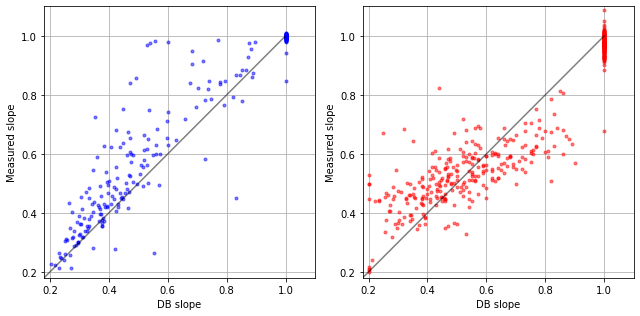

In [35]:
def plot_calibs():
    
    fig, axes = plt.subplots(1, 2, figsize=(9, 4.5))

    axes[0].plot(results.slope_t0, results.slope_t, 'b.', alpha=0.5)
    axes[1].plot(results.slope_p0, results.slope_p, 'r.', alpha=0.5)
    
    for ax in axes:
        ax.grid()
        ax.plot([0,1], [0,1], 'k-', alpha=0.5)
        ax.set(xlim=(0.18,1.1), xlabel='DB slope', ylim=(0.18,1.1), ylabel='Measured slope')
    plt.tight_layout()
    plt.savefig('calibs.png')
    
plot_calibs()

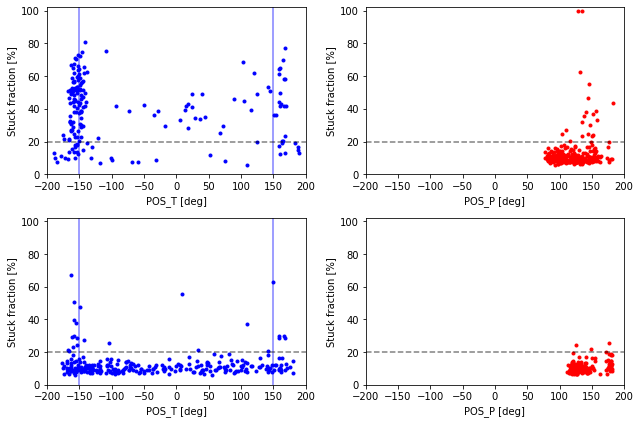

In [36]:
def plot_stuck():
    
    fig, axes = plt.subplots(2, 2, figsize=(9, 6))
    axes = axes.reshape(-1)
    
    bad = lambda slope: slope != 1
    good = lambda slope: slope == 1
    
    k = 0
    for cond in (bad, good):
        for (axis, Axis, color) in zip('tp', 'TP', 'br'):
            ax = axes[k]
            k += 1
            sel = cond(results[f'slope_{axis}0'])
            nsel = np.count_nonzero(sel)
            ax.plot(results[sel][f'{axis}stuck_val'], 100*results[sel][f'{axis}stuck_frac'],
                    '.', c=color)
            ax.set(xlabel=f'POS_{Axis} [deg]', xlim=(-200,200), ylabel=f'Stuck fraction [%]',
                   ylim=(0,102))
            if axis == 't':
                ax.axvline(-150, c='b', alpha=0.5)
                ax.axvline(+150, c='b', alpha=0.5)
            ax.axhline(20, c='k', ls='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig('stuck.png')
    
plot_stuck()


Plotting 28 randomly selected from 166
Saving promising_p.png


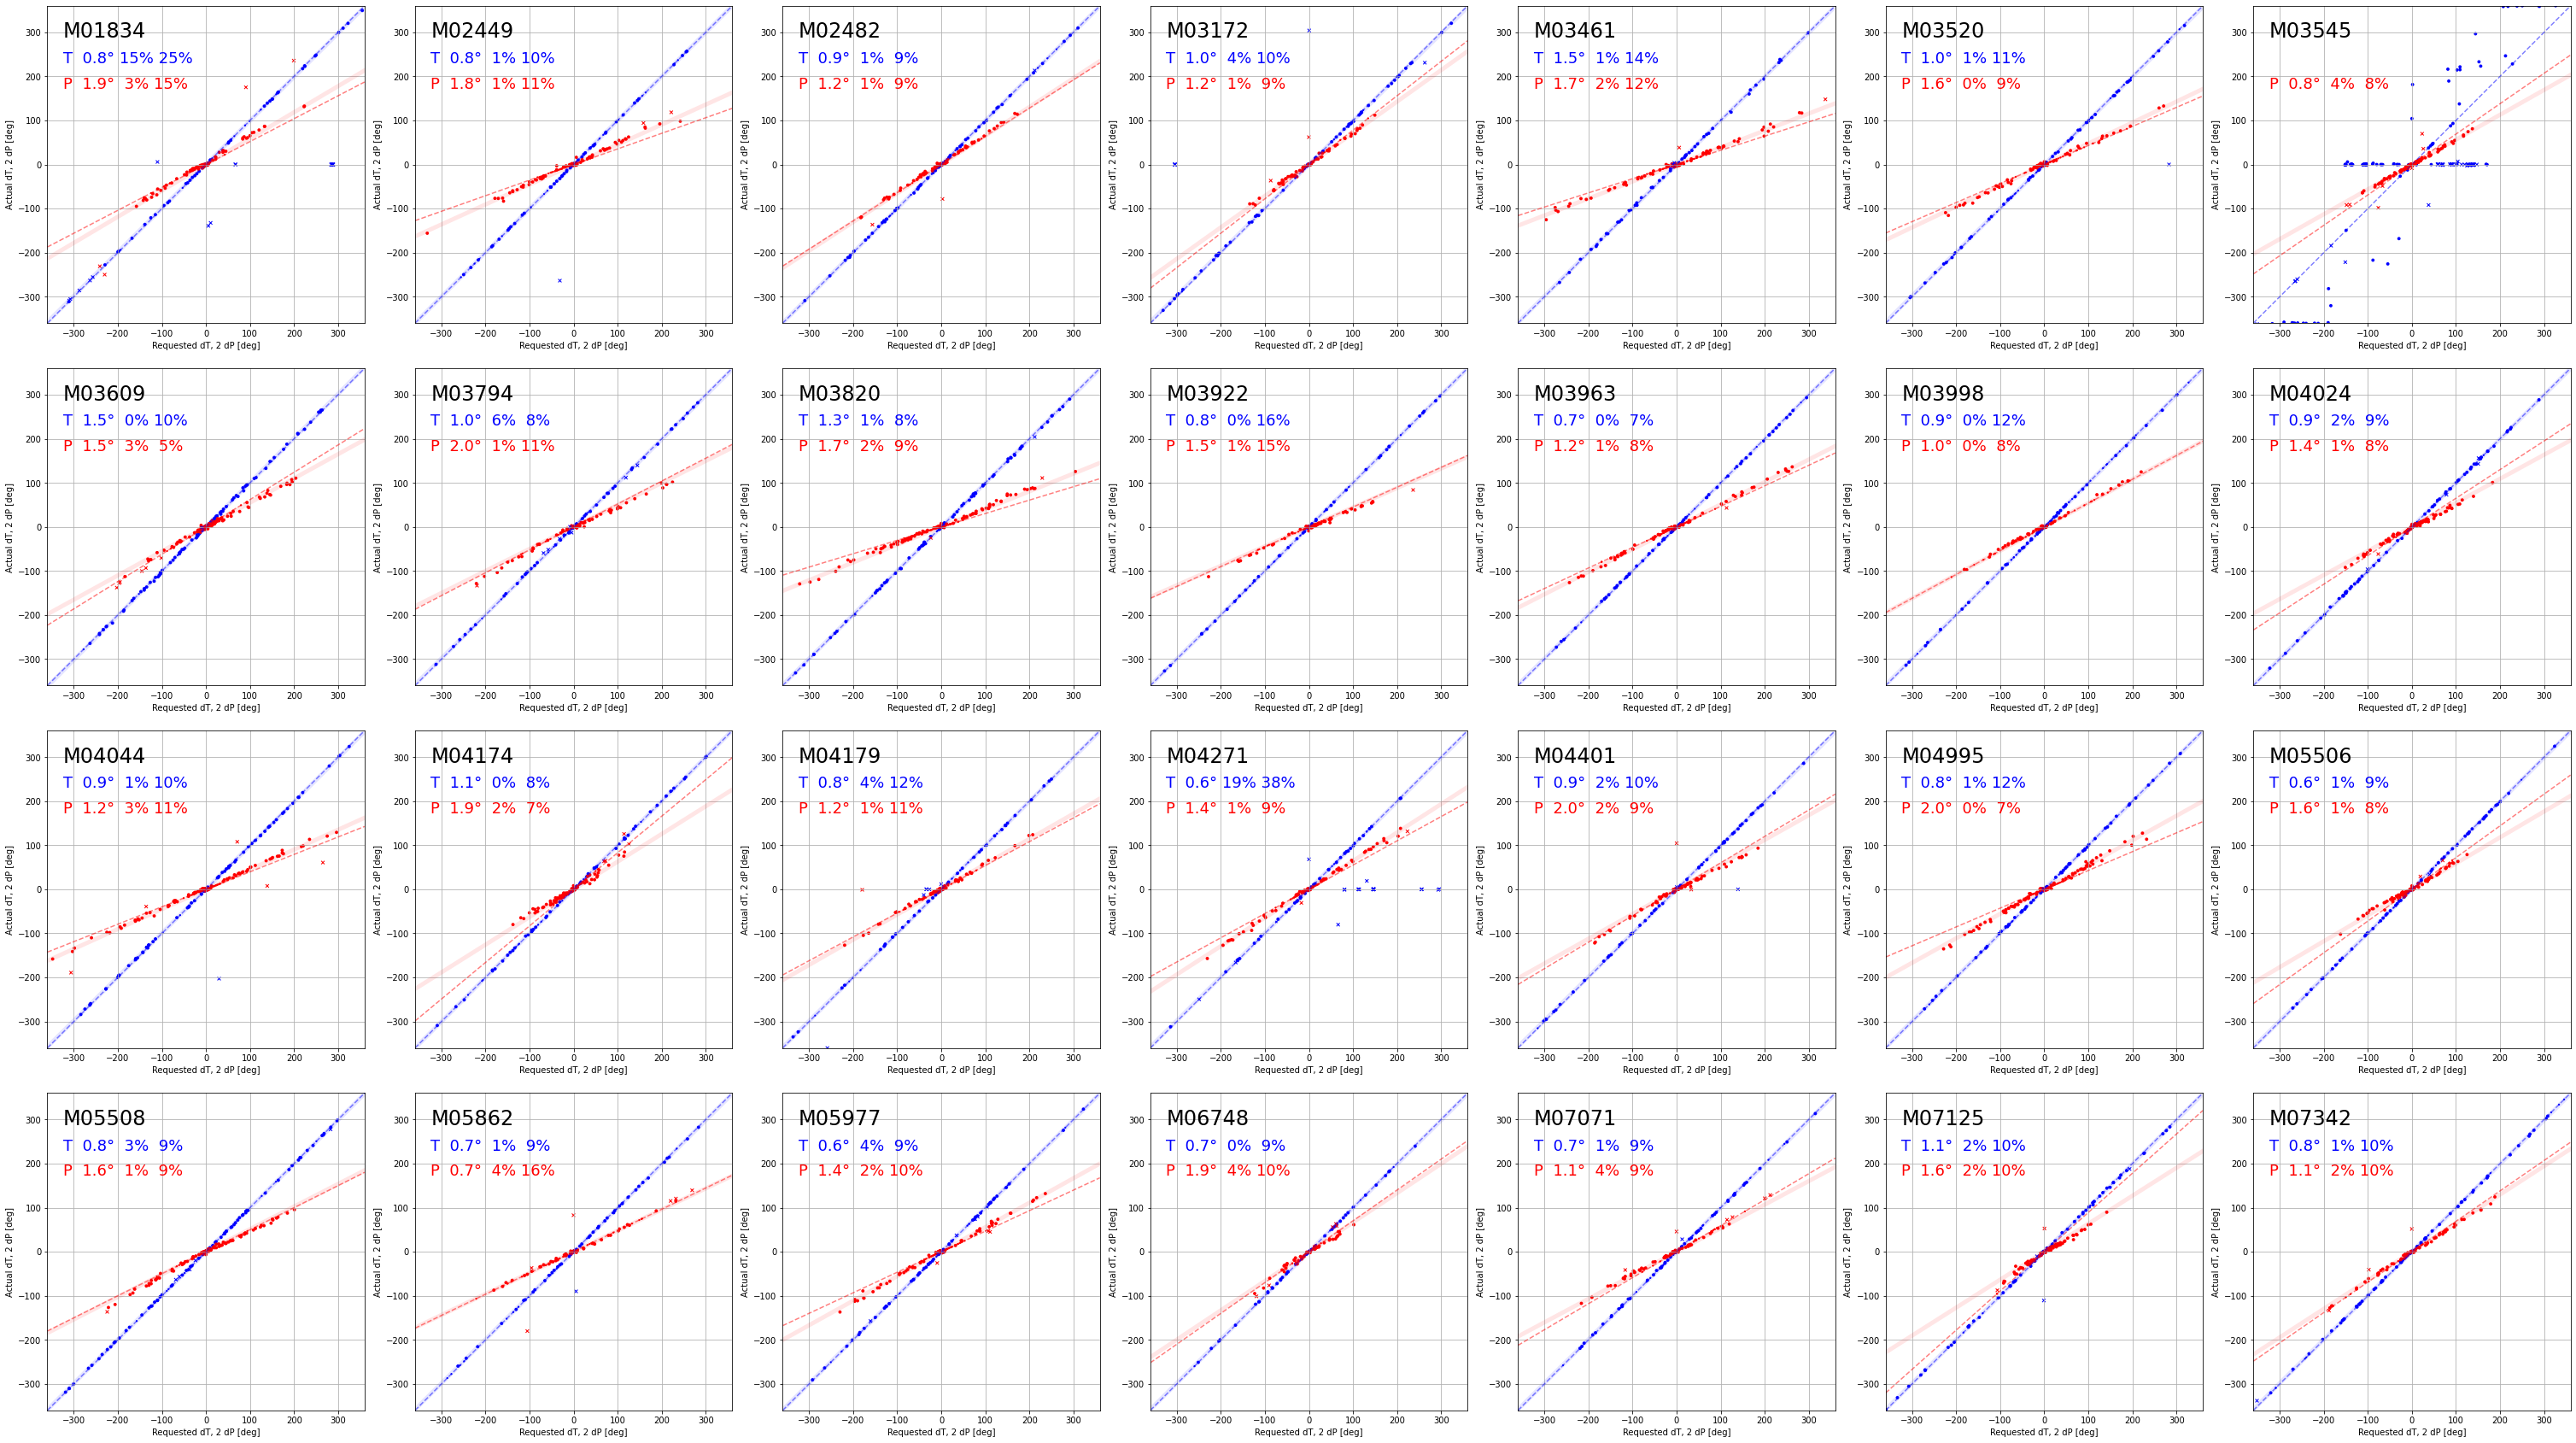

In [30]:
plot_group(
    lambda r: (r.slope_t0 == 1) & (r.ofrac_p < 0.05) & (r.rms_p < 2),
    save='promising_p.png')

Plotting 28 randomly selected from 61
Saving dubious_good.png


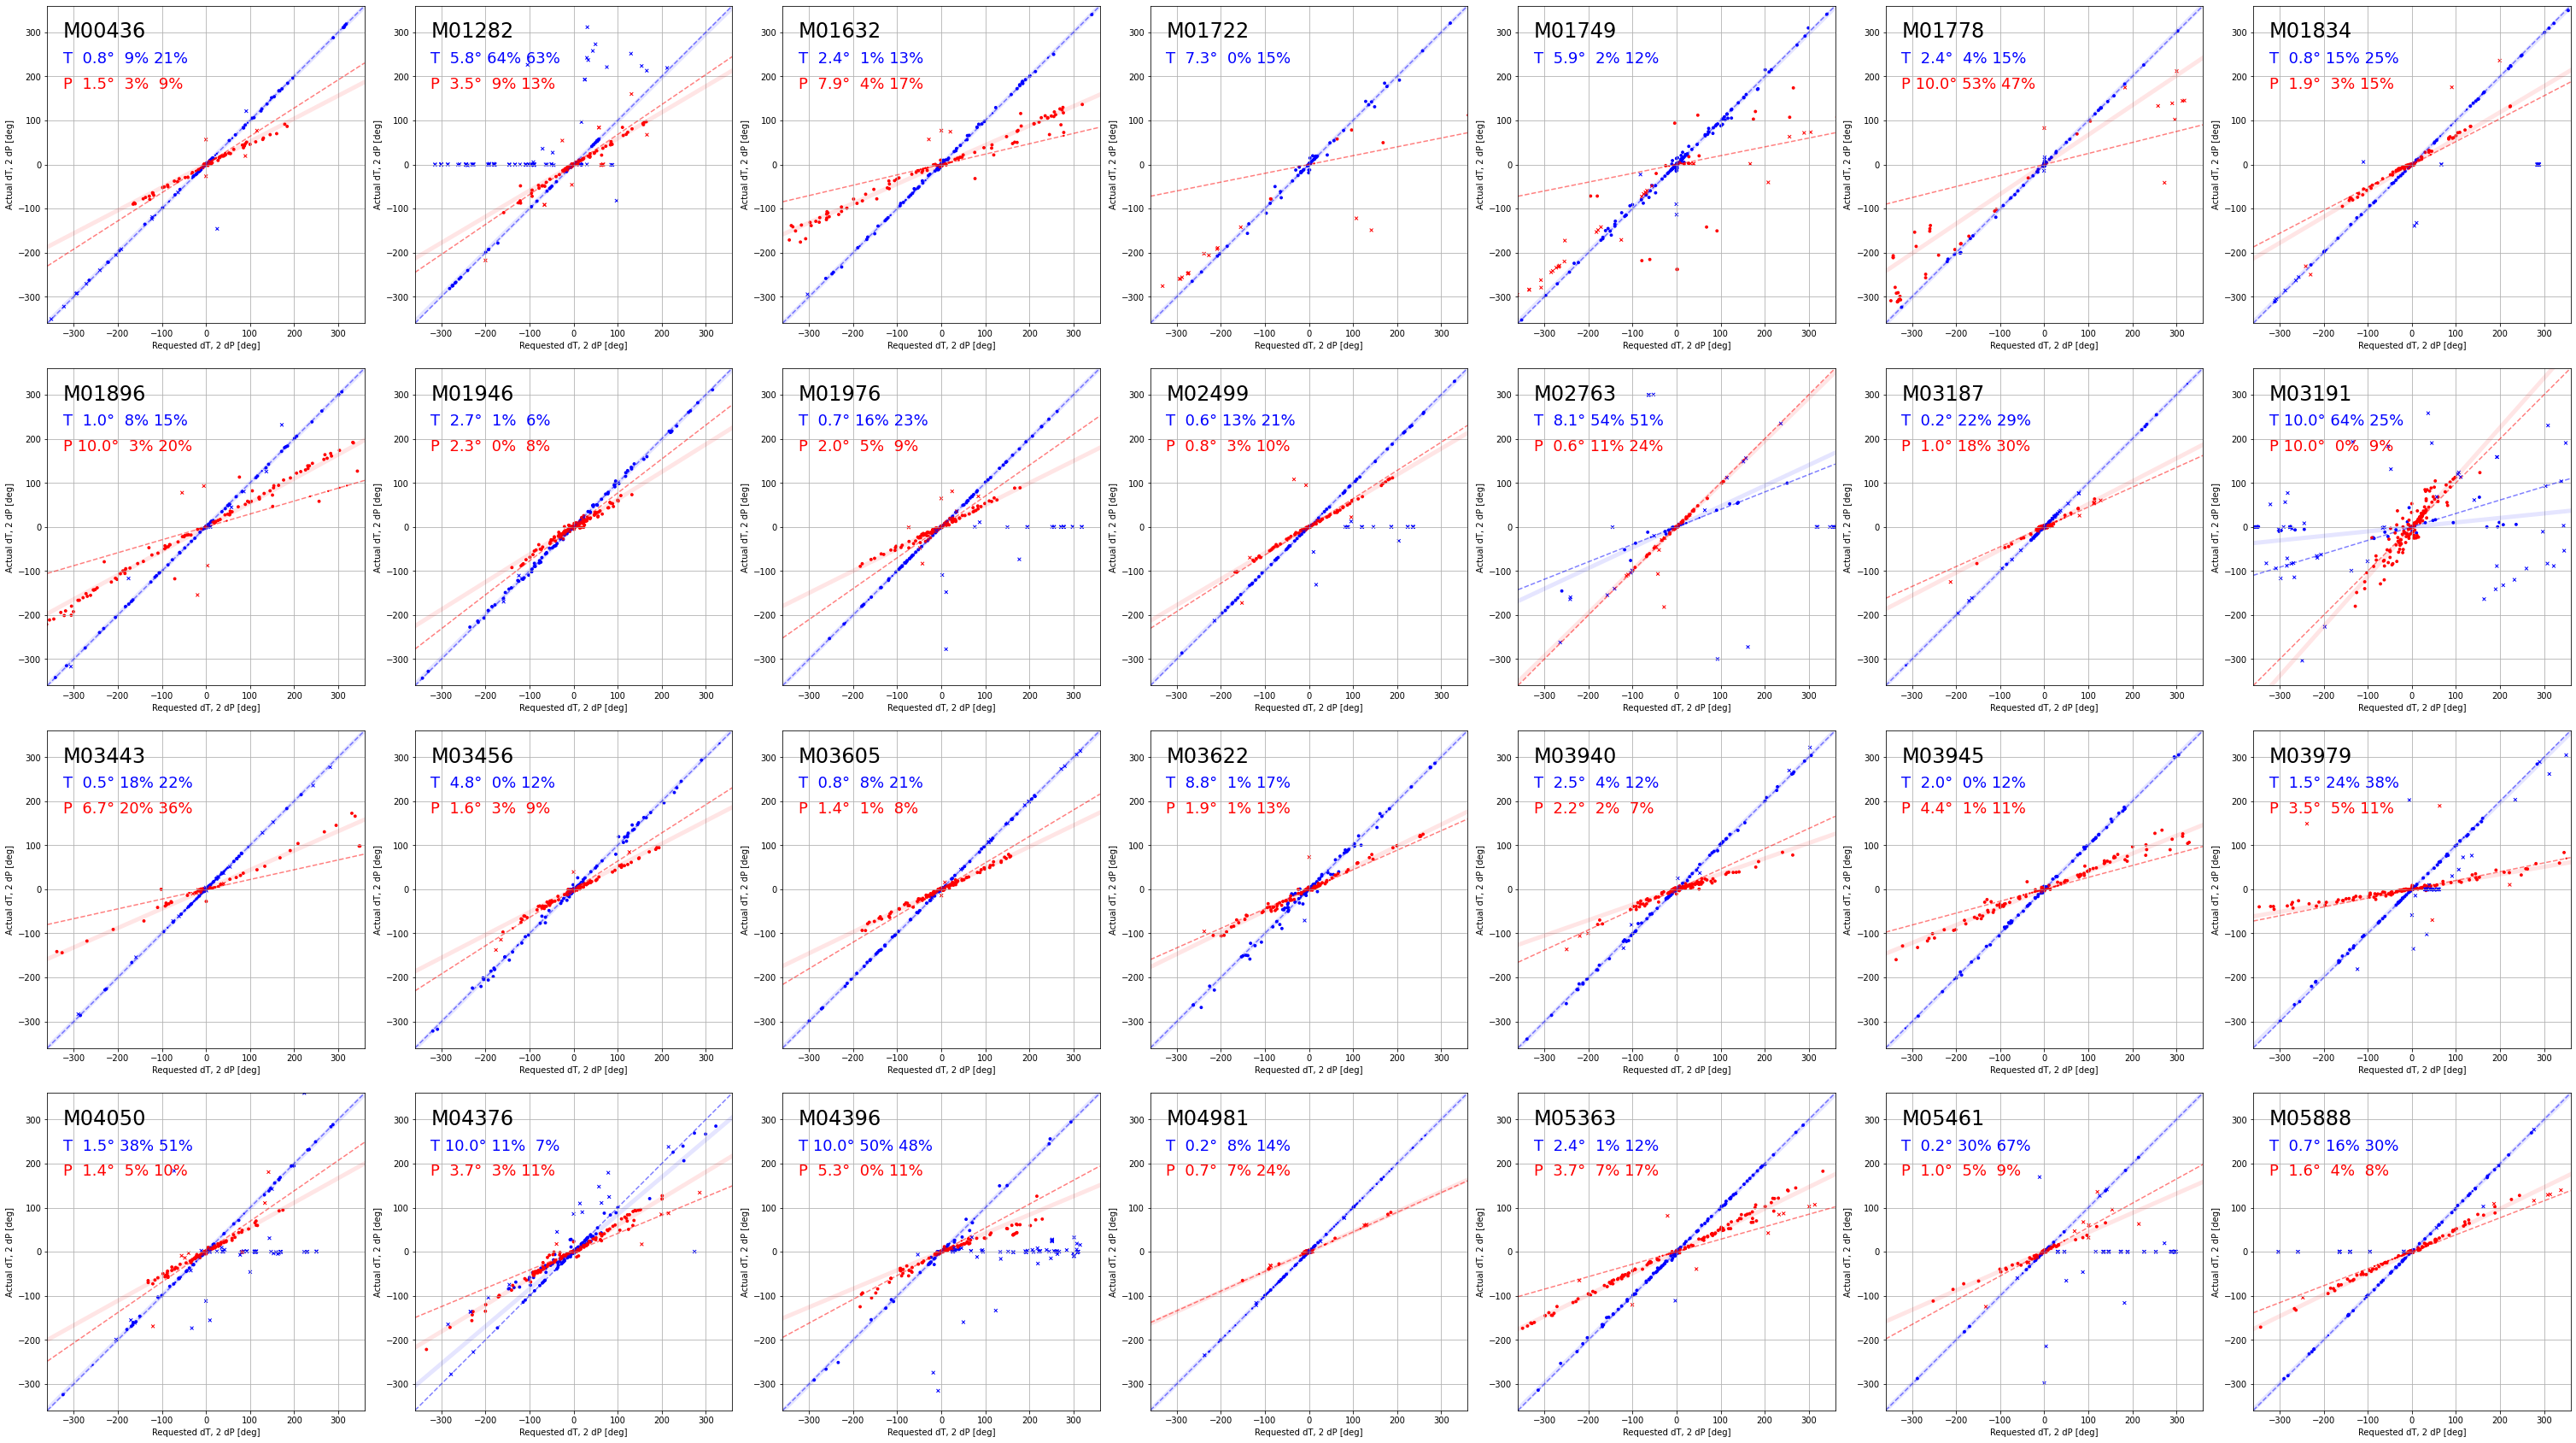

In [31]:
plot_group(
    lambda r: (
        ((r.slope_t0 == 1) & ((r.ofrac_t >= 0.05) | (r.rms_t >= 2))) |
        ((r.slope_p0 == 1) & ((r.ofrac_p >= 0.05) | (r.rms_p >= 2)))),
    save='dubious_good.png')

Plotting 28 randomly selected from 53
Saving slope_mismatch.png


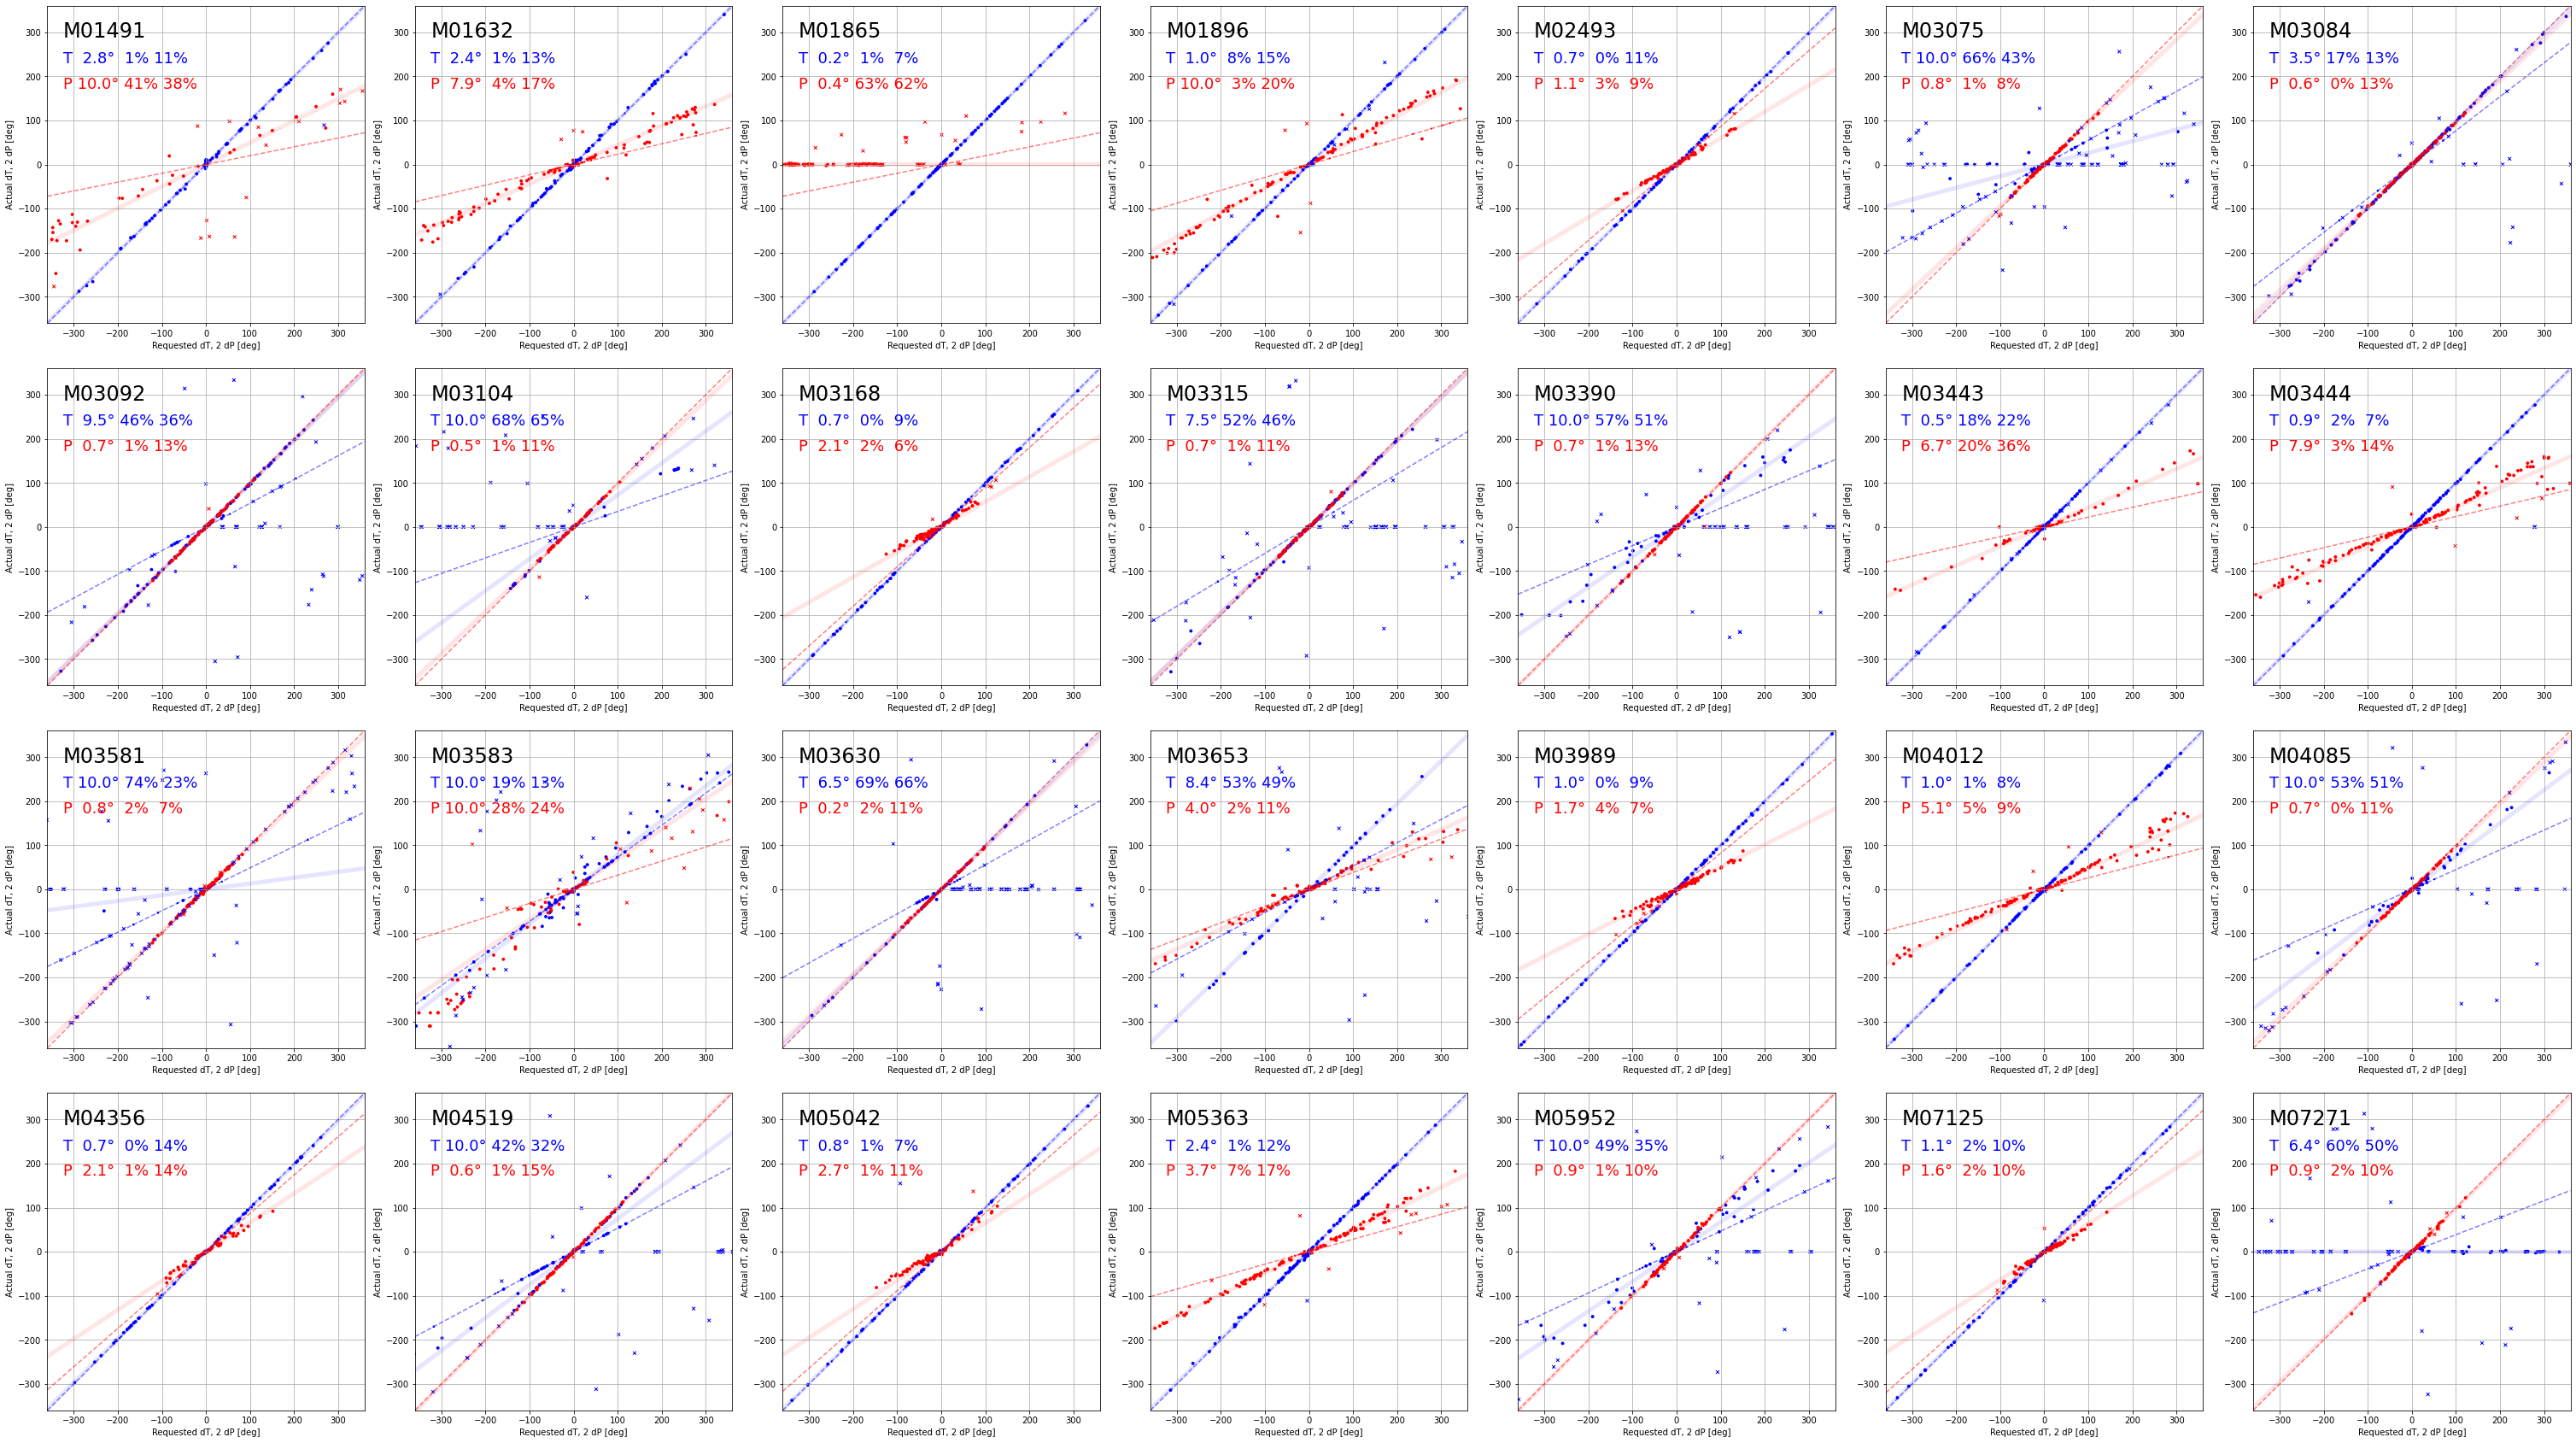

In [32]:
plot_group(
    lambda r: (
        ((r.slope_t0 < 1) & (np.abs(r.slope_t0 - r.slope_t) > 0.2)) |
        ((r.slope_p0 < 1) & (np.abs(r.slope_p0 - r.slope_p) > 0.2))),
    save='slope_mismatch.png')

Plotting 28 randomly selected from 73
Saving stuck_t.png


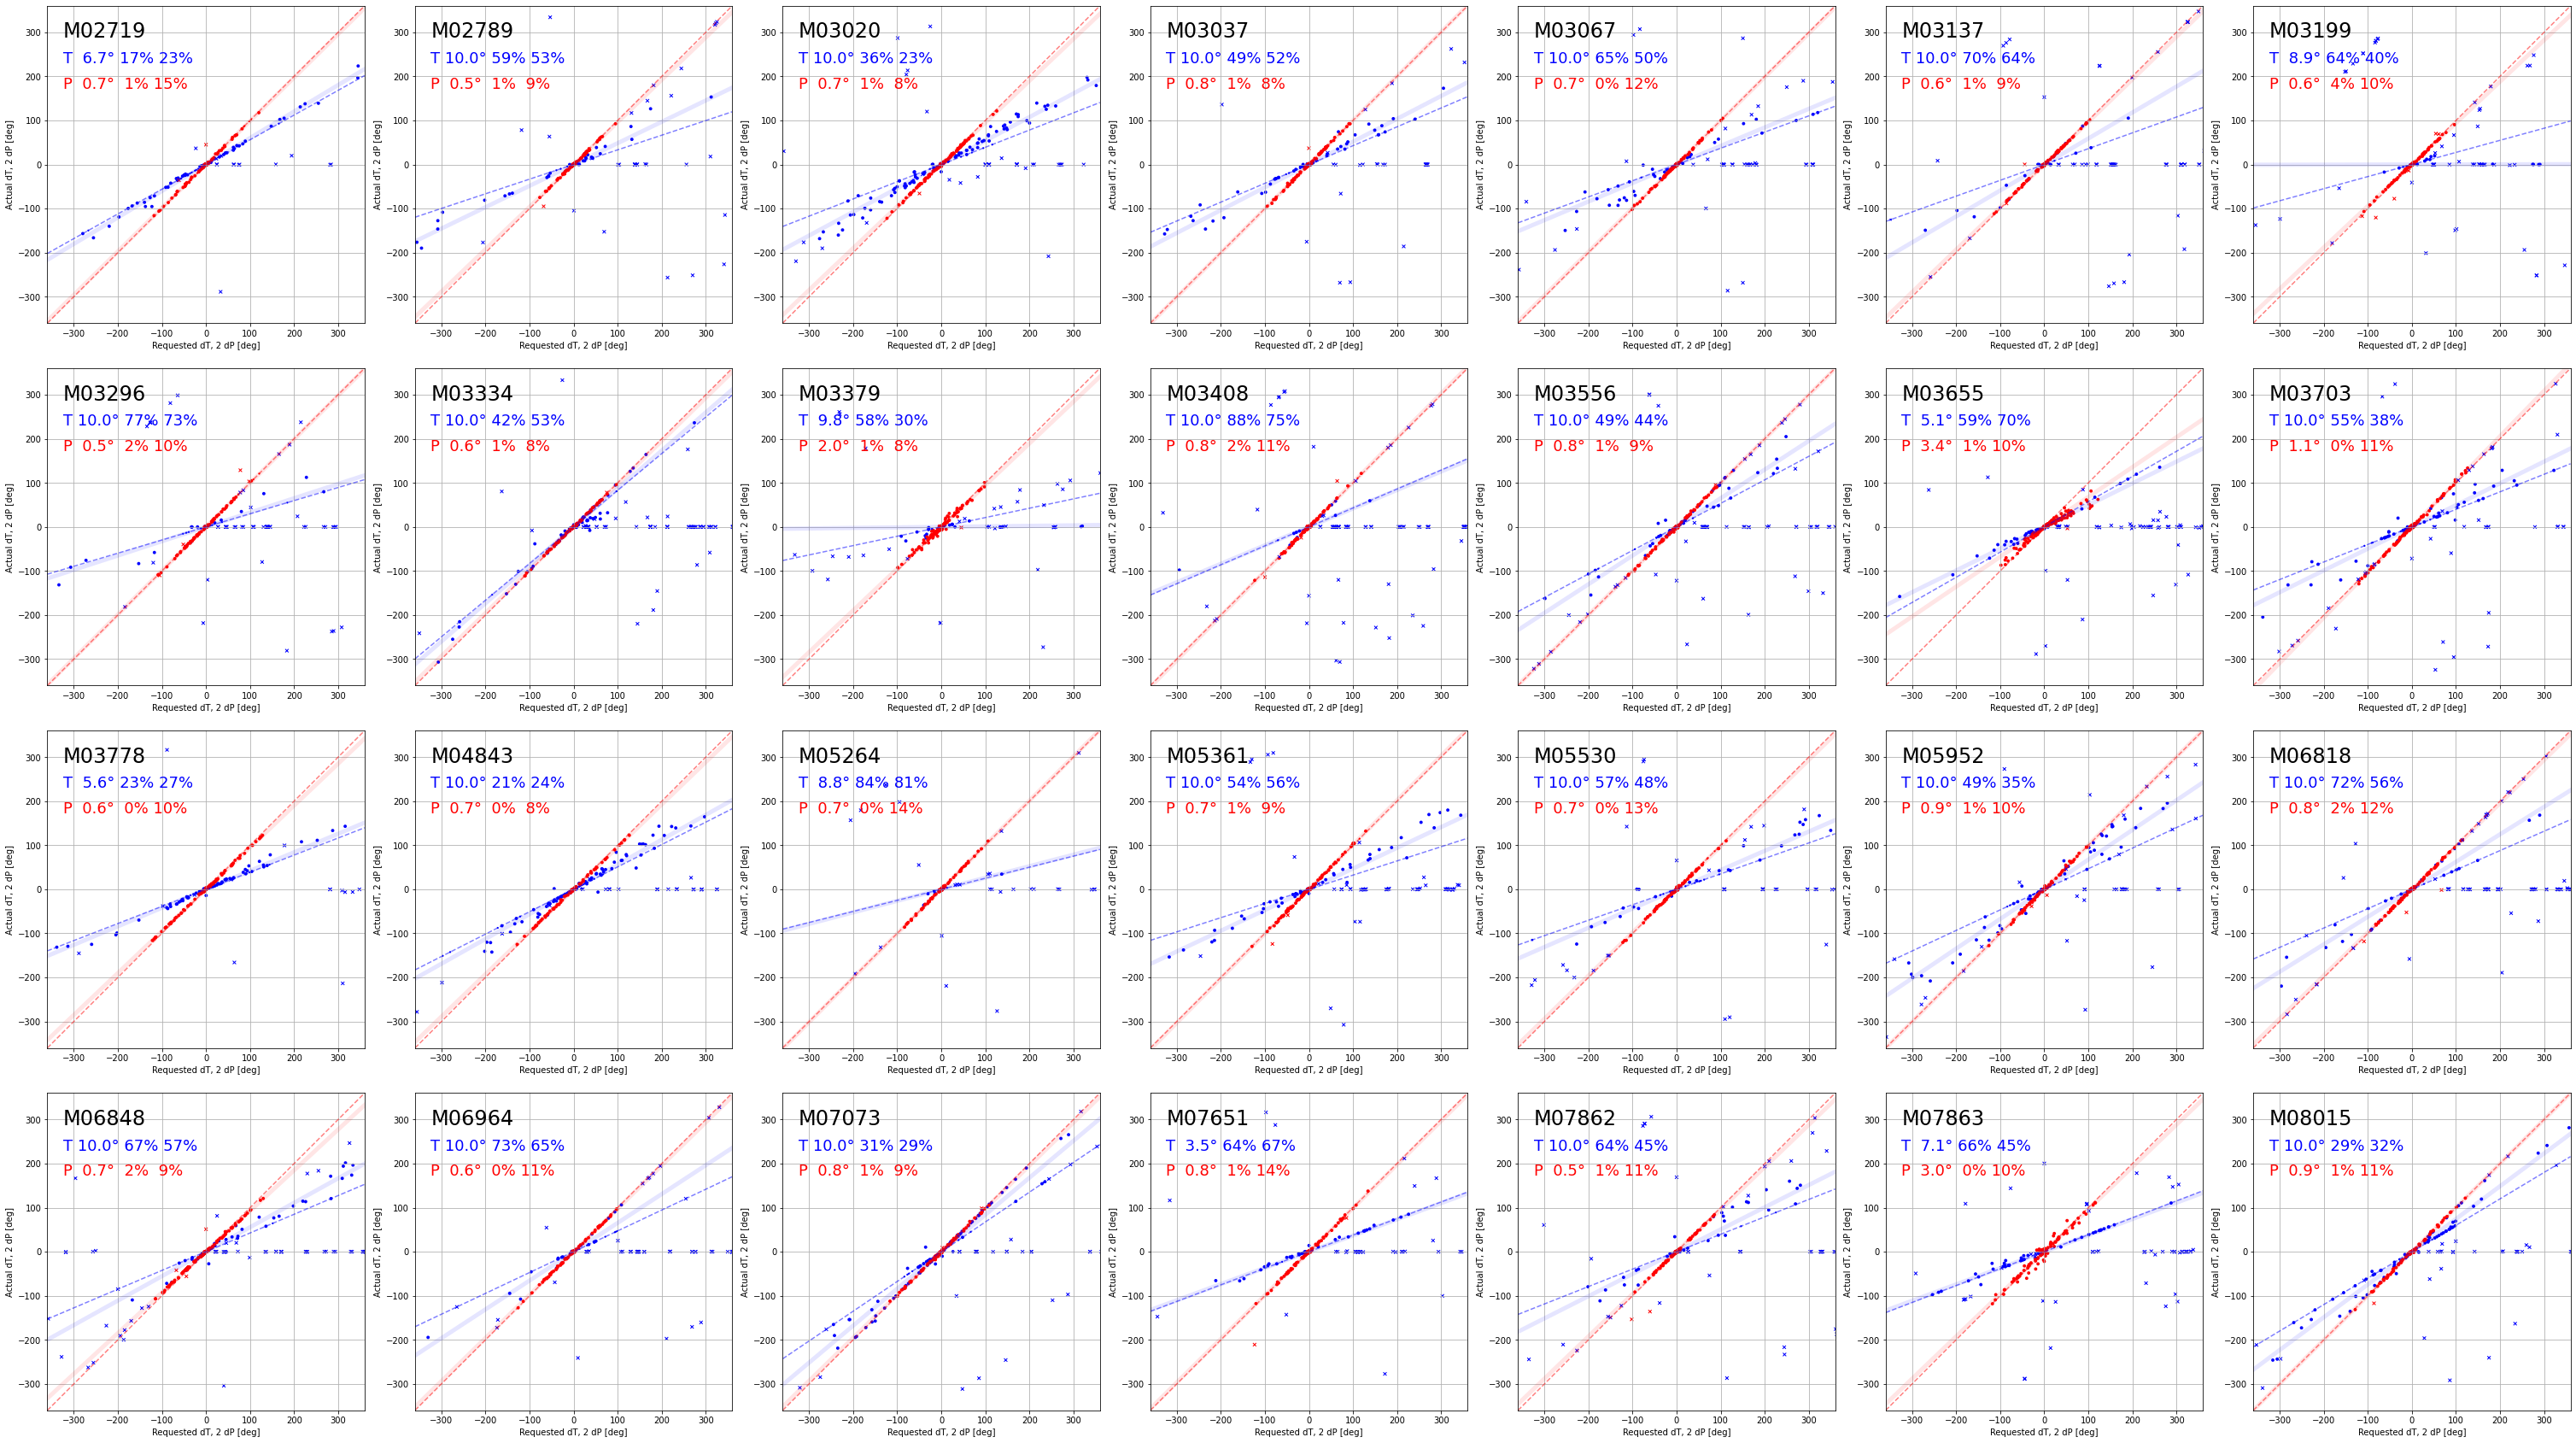

In [33]:
plot_group(
    lambda r: (r.slope_t0 < 1) & (np.abs(r.tstuck_val+150) < 10) & (r.tstuck_frac > 0.2),
    save='stuck_t.png')